# Project 2: Marketing Analysis

## Import module

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import timedelta
warnings.filterwarnings('ignore')

## Import data

In [2]:
df = pd.read_excel('Ppc_campaign_performance_data.xlsx')

In [3]:
df.head()

,Campaign_ID,Budget,Clicks,CTR,CPC,Conversions,CPA,Conversion_Rate,Duration,Platform,Content_Type,Target_Age,Target_Gender,Region,Revenue,Spend,ROAS,Date,Impressions
0,C3578,6390,401,0.0461,15.94,174,36.72,0.4339,20,Instagram,Carousel,35-44,Male,Europe,27840,6453.9,4.31,2025-01-19,8698
1,C6702,9870,1286,0.2860,7.67,821,12.02,0.6384,28,LinkedIn,Text,55+,Male,Africa,128076,10067.4,12.72,2025-01-22,4496
2,C9725,7700,1684,0.2122,4.57,1060,7.26,0.6295,15,Instagram,Video,35-44,Other,North America,193980,7623.0,25.45,2024-07-23,7935
3,C9472,8420,444,0.0961,18.96,308,27.34,0.6937,25,Google,Text,25-34,Male,North America,24024,8504.2,2.82,2024-04-20,4620
4,C7601,8470,1912,0.3652,4.43,1428,5.93,0.7469,9,Google,Text,25-34,Other,Europe,277032,8046.5,34.43,2024-08-07,5235


**Cái này tôi hơi băn khoăn vì tôi tưởng lẽ ra phải là**:  
+ CPA = Spend / Conversions
+ CPC = Spend / Clicks

**Thế nhưng tập dataset tôi nhận được lại là**:   
+ CPA = Budget / Conversions
+ CPC = Budget / Clicks


**Một vài công thức khác**:
+ Conversion_Rate = Conversions / Clicks
+ CTR = Clicks / Impressions
+ ROI = (Revenue - Spend) / Spend
+ ROAS = Revenue / Spend = 1 + ROI


## Cleaning data

### Kiểm tra kiểu dữ liệu

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Campaign_ID      1000 non-null   object 
 1   Budget           1000 non-null   int64  
 2   Clicks           1000 non-null   int64  
 3   CTR              1000 non-null   float64
 4   CPC              1000 non-null   float64
 5   Conversions      1000 non-null   int64  
 6   CPA              1000 non-null   float64
 7   Conversion_Rate  1000 non-null   float64
 8   Duration         1000 non-null   int64  
 9   Platform         1000 non-null   object 
 10  Content_Type     1000 non-null   object 
 11  Target_Age       1000 non-null   object 
 12  Target_Gender    1000 non-null   object 
 13  Region           1000 non-null   object 
 14  Revenue          1000 non-null   int64  
 15  Spend            1000 non-null   float64
 16  ROAS             1000 non-null   float64
 17  Date           

-> Không có giá trị null, kiểu dữ liệu tương đối chuẩn, có vẻ như dữ liệu đã được người cung cấp trước đó làm sạch.  
-> Ta sẽ đổi kiểu dữ liệu của Date sang datetime

In [5]:
df["Date"] = pd.to_datetime(df["Date"])

### Kiểm tra trùng lặp

In [6]:

df["Campaign_ID"].duplicated().sum()

np.int64(46)

Nhưng có thực sự là vậy không ? Ta cần chú ý đến liệu có phải rằng chiến dịch sẽ được thực hiện dở dang chưa hoàn thành nốt không ?

In [7]:
df["Campaign_ID"].value_counts()

Campaign_ID
C5910    3
C5327    2
C2099    2
C6702    2
C9725    2
        ..
C4071    1
C2402    1
C3257    1
C4315    1
C9612    1
Name: count, Length: 954, dtype: int64

In [8]:
df[df["Campaign_ID"] == "C5910"] 

,Campaign_ID,Budget,Clicks,CTR,CPC,Conversions,CPA,Conversion_Rate,Duration,Platform,Content_Type,Target_Age,Target_Gender,Region,Revenue,Spend,ROAS,Date,Impressions
272,C5910,4310,577,0.1408,7.47,188,22.93,0.3258,7,Facebook,Carousel,18-24,Other,Africa,20868,4223.8,4.94,2024-08-15,4098
351,C5910,7760,1931,0.7453,4.02,1221,6.36,0.6323,29,YouTube,Image,18-24,Other,Europe,238095,8148.0,29.22,2024-06-29,2590
827,C5910,7160,293,0.2169,24.44,291,24.60,0.9932,17,LinkedIn,Video,55+,Other,Asia,49179,7374.8,6.67,2024-04-23,1350


-> Có vẻ cùng Campaign_ID thế nhưng thông tin chiến dịch lại khác nhau. Ta quyết định giữ lại tất cả các bản ghi vì có thể các chiến dịch này được tái khởi động lại vì một vài lý do nào đó (Có thể do thay đổi khu vực do tôi thấy Region có thay đổi, hoặc có thể là kiểm tra xem chiến dịch có còn hiệu quả không do tôi chiến dịch ở khoảng thời gian gần nhất thấy spend rất nhỏ giọt so với trước đó)

### Create new featuress

In [9]:
# Thêm một vài cột
df["Profit"] = df["Revenue"] - df["Spend"]
df["ROI"] = df["ROAS"] - 1

In [10]:
df["Day"] = df["Date"].dt.day
df["Month"] = df["Date"].dt.month
df["Year"] = df["Date"].dt.year
df["Weekday"] = df["Date"].dt.day_name()

In [11]:
df["Month_Year"] = df["Date"].dt.to_period("M")

In [12]:
df.head()

,Campaign_ID,Budget,Clicks,CTR,CPC,Conversions,CPA,Conversion_Rate,Duration,Platform,...,ROAS,Date,Impressions,Profit,ROI,Day,Month,Year,Weekday,Month_Year
0,C3578,6390,401,0.0461,15.94,174,36.72,0.4339,20,Instagram,...,4.31,2025-01-19,8698,21386.1,3.31,19,1,2025,Sunday,2025-01
1,C6702,9870,1286,0.2860,7.67,821,12.02,0.6384,28,LinkedIn,...,12.72,2025-01-22,4496,118008.6,11.72,22,1,2025,Wednesday,2025-01
2,C9725,7700,1684,0.2122,4.57,1060,7.26,0.6295,15,Instagram,...,25.45,2024-07-23,7935,186357.0,24.45,23,7,2024,Tuesday,2024-07
3,C9472,8420,444,0.0961,18.96,308,27.34,0.6937,25,Google,...,2.82,2024-04-20,4620,15519.8,1.82,20,4,2024,Saturday,2024-04
4,C7601,8470,1912,0.3652,4.43,1428,5.93,0.7469,9,Google,...,34.43,2024-08-07,5235,268985.5,33.43,7,8,2024,Wednesday,2024-08


### **Dashboard 1: Phân tích tổng quan hiệu suất**

1. Các thẻ chỉ số KPI

In [13]:
# Định nghĩa card
def card_plot(title, value):
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.text(0.5, 0.5, f'{title}\n\n{value}', 
            fontsize=18, fontweight='bold', ha='center', va='center',
            bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.8))
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')
    plt.show()

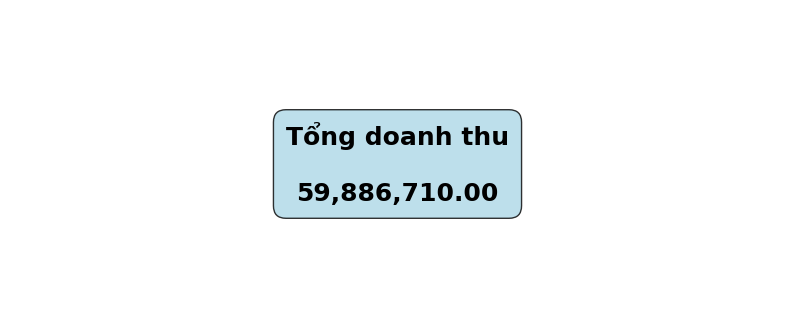

In [14]:
# Tổng lợi nhuận cho đến thời điểm hiện tại
total_revenue = df["Revenue"].sum()
card_plot("Tổng doanh thu", f'{total_revenue:,.2f}')

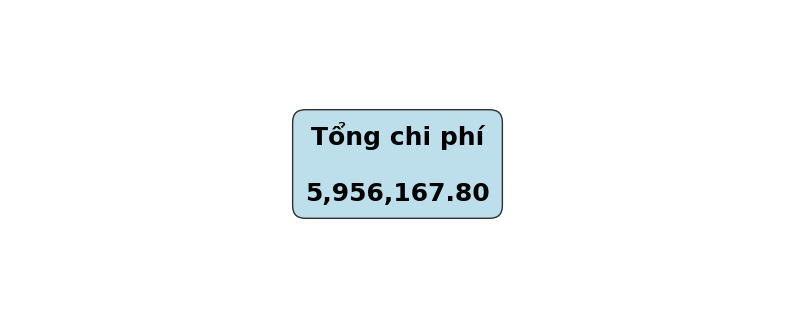

In [15]:
# Tổng lợi nhuận cho đến thời điểm hiện tại
total_spend = df["Spend"].sum()
card_plot("Tổng chi phí", f'{total_spend:,.2f}')

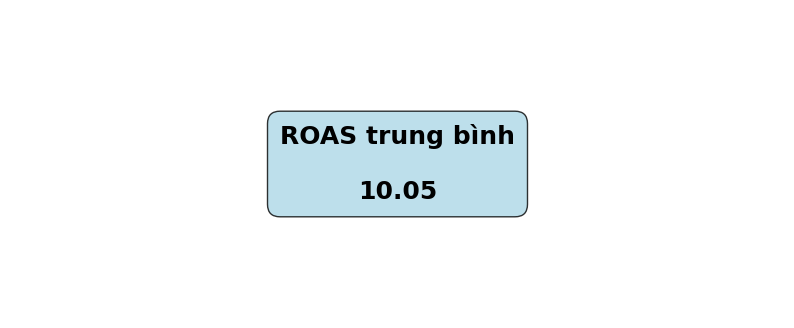

In [16]:
# ROAS trung bình
avg_roas = total_revenue / total_spend
card_plot("ROAS trung bình", f'{avg_roas:.2f}')

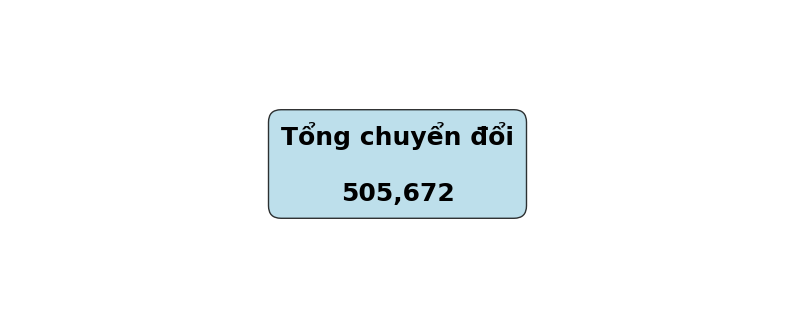

In [17]:
# Tổng chuyển đổi
total_conversions = df["Conversions"].sum()
card_plot("Tổng chuyển đổi", f'{total_conversions:,.0f}')

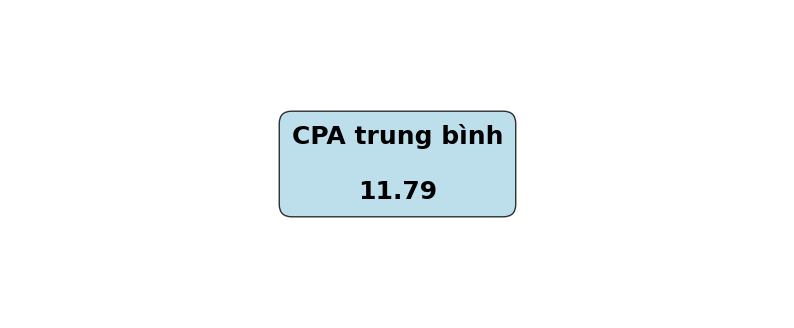

In [18]:
# CPA trung bình
avg_cpa = df["Budget"].sum() / total_conversions
card_plot("CPA trung bình", f'{avg_cpa:.2f}')

2. Các biểu đồ liên quan đến xu hướng thời gian

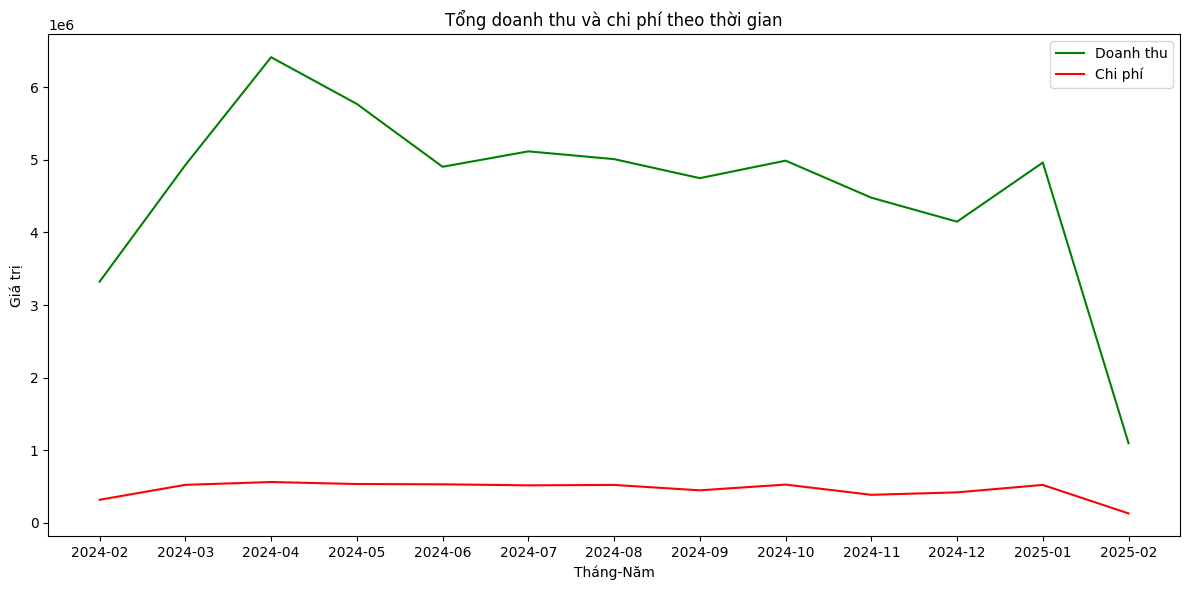

In [19]:
fig, ax1 = plt.subplots(figsize=(12, 6))

monthly_values = df.groupby("Month_Year").agg({"Revenue": "sum", "Spend": "sum"}).reset_index()
monthly_values["Month_Year"] = monthly_values["Month_Year"].astype(str)


sns.lineplot(data=monthly_values, x="Month_Year", y="Revenue", label="Doanh thu", color="green", ax=ax1)
sns.lineplot(data=monthly_values, x="Month_Year", y="Spend", label="Chi phí", color="red", ax=ax1)
ax1.set_xlabel("Tháng-Năm")
ax1.set_ylabel("Giá trị")
ax1.tick_params(axis='y')
ax1.set_title("Tổng doanh thu và chi phí theo thời gian")
plt.tight_layout()
plt.show()

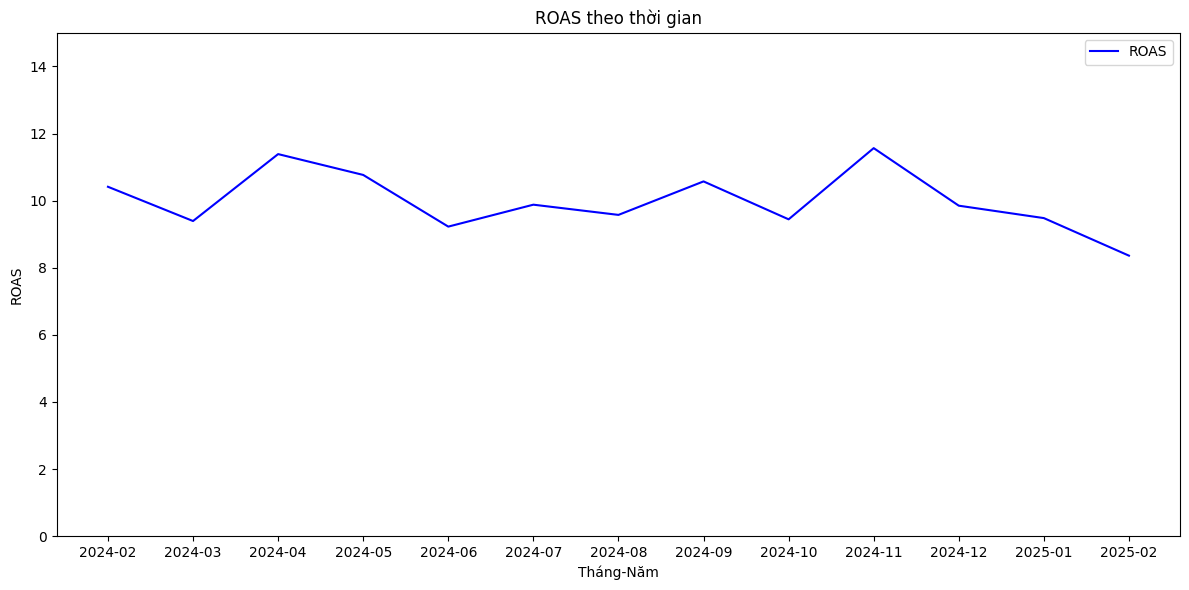

In [20]:
plt.figure(figsize=(12, 6))
monthly_values["ROAS"] = monthly_values["Revenue"] / monthly_values["Spend"]
sns.lineplot(data=monthly_values, x="Month_Year", y="ROAS", label="ROAS", color="blue")
plt.title("ROAS theo thời gian")
plt.xlabel("Tháng-Năm")
plt.ylabel("ROAS")
plt.ylim(0,15)
plt.tight_layout()
plt.show()

-> ROAS tương đối ổn định

**Chúng ta cùng stop ở đây một chút, có vài vấn đề ở đây tôi cần giải quyết**:
1. Tại sao ROAS 2025-02 lại giảm mạnh so với các năm khác như vậy ?
2. Tại sao 2024-04 revenue tăng mạnh như vậy ?
3. Tại sao 2024-11 thì ROAS lại tăng vậy rồi lại giảm ?

**1. Tại sao ROAS 2025-02 lại giảm mạnh so với các năm khác vậy ?**

In [21]:
# Giả thuyết 1: Do dữ liệu chưa được cập nhật nốt ?

In [22]:
# Ta xem ngày cuối cùng cập nhật dữ liệu
df.Date.max()

Timestamp('2025-02-09 00:00:00')

-> Ngày 9/2, dường như giả thuyết ta đặt ra là đúng. Tuy nhiên tôi cần kiểm tra thêm so với các chiến dịch trước đó thì sao ?

In [23]:
df[df["Date"].dt.year == 2025][df["Date"].dt.month == 1]["Date"].value_counts().sum()

np.int64(90)

-> Như tháng trước đó thì có rất nhiều chiến dịch và chiến dịch cuối cùng được thực hiện là 31/1, tức dữ liệu được cập nhật rất đầy đủ

In [24]:
# So với tháng cuối năm này
len(df[df["Month_Year"]==df.Month_Year.max()])

22

-> Chỉ có duy nhất 22 record, dữ liệu chưa được cập nhật hết


**2. Tại sao 2024-04 revenue tăng mạnh như vậy ?**

In [25]:
# Giả thuyết 1: Do số lượng chiến dịch có thể đã tăng lên vào tháng đó

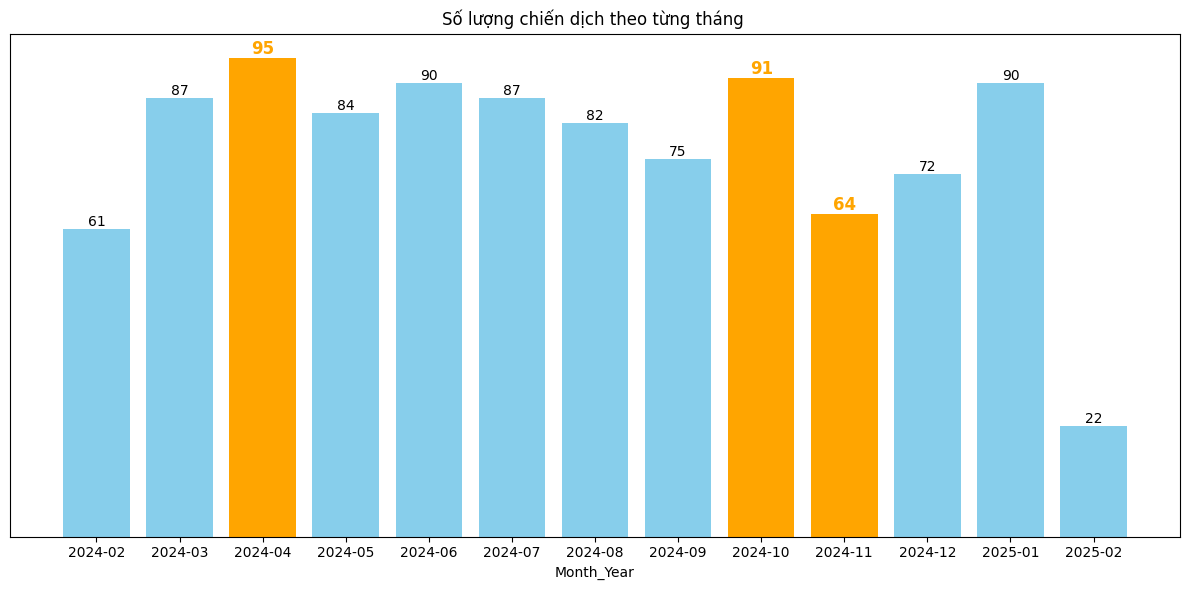

In [26]:
campaign_counts = df.groupby("Month_Year")["Campaign_ID"].count().reset_index()
campaign_counts["Month_Year"] = campaign_counts["Month_Year"].astype(str)

highlight_month = ["2024-04", "2024-11", "2024-10"]

colors = ['orange' if month in highlight_month else 'skyblue' for month in campaign_counts["Month_Year"]]

plt.figure(figsize=(12,6))
bars = plt.bar(campaign_counts["Month_Year"], campaign_counts["Campaign_ID"], color=colors)

for bar, month, count in zip(bars, campaign_counts["Month_Year"], campaign_counts["Campaign_ID"]):
    if month in(highlight_month):
        plt.text(
            bar.get_x() + bar.get_width() / 2, 
            bar.get_height(), 
            str(count), 
            ha='center', 
            va='bottom', 
            fontsize=12,
            color='orange',
            fontweight='bold'
        )
    else:
        plt.text(
            bar.get_x() + bar.get_width() / 2, 
            bar.get_height(), 
            str(count), 
            ha='center', 
            va='bottom', 
            fontsize=10
        )

plt.xlabel("Month_Year")
plt.gca().axes.get_yaxis().set_visible(False)
plt.title("Số lượng chiến dịch theo từng tháng ")
plt.tight_layout()
plt.show()

-> Giả thuyết đưa ra là hợp lý, tháng đó có số lượng chiến dịch là lớn hơn tất cả các tháng khác

In [27]:
# Thế nhưng, nếu để ý vào ROAS, ta nhận thấy rằng mặc dù có chiến dịch nhiều thế nhưng so với 2024-11 thì 2024-11 lại có ROAS là nhỉnh hơn chút. 
# Mặc dù là số lượng chiến dịch ở 2024-11 là ít hơn đáng kể (chỉ có khoảng 64)

**3. Ta tập trung vào phân tích 2024-11**

? Tại sao tháng này ROAS lại cao hơn cả 2024-04 ?

In [28]:
# Giả thuyết 1: Do ROAS = Revenue / Spend nên có thể là do Revenue tăng hoặc giữ nguyên so với các tháng trước nhưng Spend giảm
# Hoặc có thể là vẫn spend so với các tháng trước nhưng Revenue lại tăng

-> Đối chiếu với hình ảnh đồ thị trên thì doanh thu giảm, tuy vậy chi phí cũng giảm luôn :D tạm thời tôi chưa kết luận được gì

In [29]:
# Giả thuyết 2: Có thể là do tháng trước đó các chiến dịch được thực hiện nhiều tuy nhiên ROAS lại kém hiệu quả
# Sang tháng này thì chỉ tập trung các chiến dịch mang tính hiệu quả.

Tại sao giả thuyết 2 đưa ra này tôi cho là hợp lý tại thời điểm này ?
1. Vì nó giải thích được lý do tại sao chi phí giảm (có thể là do chiến dịch ít hơn ?)
2. Vì nó giải quyết được lý do tại sao doanh thu giảm đi (ít chiến dịch đi thì số tiền kiếm về cũng có thể ít hơn ?)

In [30]:
# Ta tiếp tục quan tâm đến số lượng chiến dịch theo từng tháng ở trên
# như ta thấy tháng 10 có số lượng chiến dịch tăng đáng kể gần đạt đỉnh 91 so với tháng cao nhất là 95 
# thế nhưng qua tháng 11 thì nó lại giảm gần kịch khung 64 so với tháng thấp nhất là 61.

-> Giả thuyết chúng ta đang được củng cố

In [31]:
# Tôi sẽ xem xem các chiến dịch nào của tháng 11 trùng với tháng trước đó
campaign_11_2024 = df[df["Month_Year"] == "2024-11"]
campaign_10_2024 = df[df["Month_Year"] == "2024-10"]

In [32]:
campaign_10_11 = np.intersect1d(campaign_11_2024["Campaign_ID"].unique(), campaign_10_2024["Campaign_ID"].unique())
campaign_10_11

array(['C4126', 'C5312', 'C6119', 'C9240'], dtype=object)

-> Có 4 campagin là trùng. Ta cùng kiểm chứng xem 4 campaign này có thực sự là hiệu quả trong tháng 10 không

In [33]:
# Các chỉ số đo sự hiệu quả của 1 chiến dịch tôi sẽ sử dụng: 
# 1. ROAS (Hiệu quả về mặt tài chính)
# 2. Profit (Hiệu quả về mặt tài chính)
# 3. CPA (Hiệu quả chuyển đổi)

In [34]:
# Kiểm tra xem có Campaign_ID nào bị trùng lặp không
campaign_10_2024.duplicated(subset=["Campaign_ID"]).sum()

np.int64(0)

In [35]:
# -> Không tồn tại campaign nào trùng lặp cả

In [36]:
def top_10_campaign_by(col_name):
    global campaign_10_11
    top_10_campaign_10_2024 = campaign_10_2024.sort_values(by=col_name, ascending=False).head(10)

    highlight_color = "#FF5733"  
    default_color = "#3498DB"    

    colors = top_10_campaign_10_2024['Campaign_ID'].apply(
        lambda x: highlight_color if x in campaign_10_11 else default_color
    ).values

    sns.barplot(
        x="Campaign_ID",
        y=col_name,
        data=top_10_campaign_10_2024,
        palette=colors
    )

    plt.title(f"Top 10 Campaigns by {col_name} in October 2024")
    plt.show()
    
    return top_10_campaign_10_2024.index

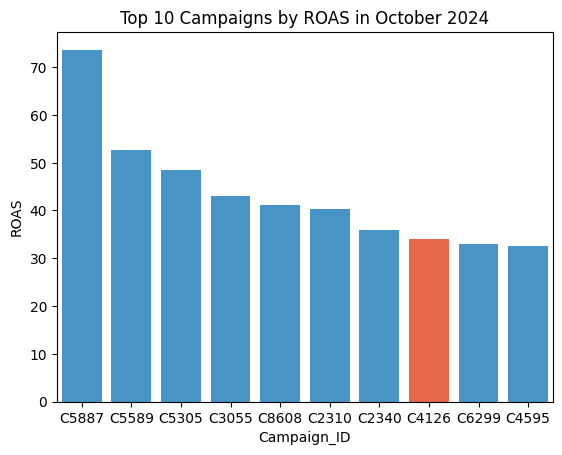

Index([92, 166, 803, 201, 894, 66, 221, 157, 367, 940], dtype='int64')

In [37]:
top_10_campaign_by("ROAS")

-> Trong tháng 10, trong top 10 campaign có ROAS cao nhất thì chỉ duy nhất tồn tại C4216 là có xuất hiện.

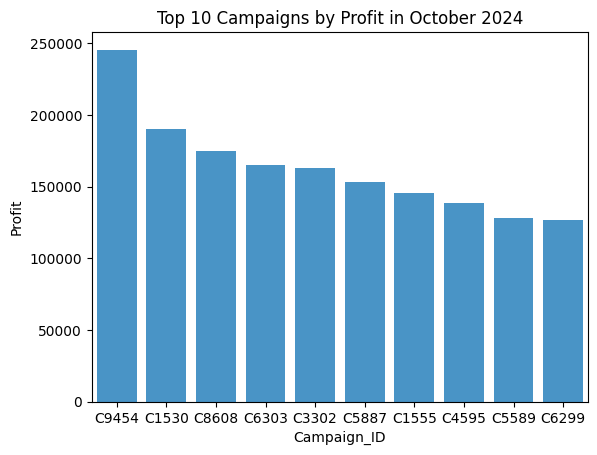

Index([181, 935, 894, 461, 447, 92, 198, 940, 166, 367], dtype='int64')

In [38]:
top_10_campaign_by("Profit")

-> Không tồn tại campaign trùng

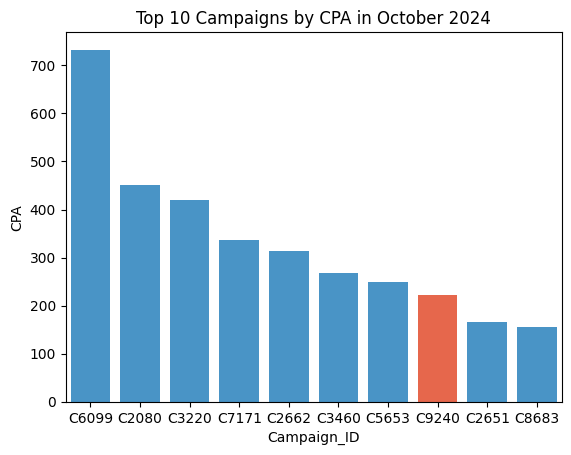

Index([172, 895, 26, 642, 776, 484, 355, 594, 359, 704], dtype='int64')

In [39]:
top_10_campaign_by("CPA")

-> Tồn tại duy nhất Campaign C9240 có mặt

**Kết luận giả thuyết**: Việc chiến dịch tháng 11 giảm đi so với tháng 10 KHÔNG PHẢI là giữ lại những chiến dịch hoạt động hiệu quả của tháng trước.

In [40]:
# Chiến thuật: So sánh chiến dịch tháng 11 so với tháng có hiệu quả hoạt động không hề kém cạnh - tháng 4

In [41]:
campaign_4_2024 = df[df['Month_Year'] == '2024-04']

In [42]:
# 1. Phân tích chi tiết tháng 11-2024
print("=== PHÂN TÍCH CHI TIẾT THÁNG 11-2024 ===")

print(f"Số chiến dịch tháng 11: {len(campaign_11_2024)}")
print(f"ROAS tháng 11: {campaign_11_2024['Revenue'].sum() / campaign_11_2024['Spend'].sum():.2f}")
print(f"Doanh thu trung bình mỗi chiến dịch: {campaign_11_2024['Revenue'].mean():.2f}")
print(f"Chi phí trung bình mỗi chiến dịch: {campaign_11_2024['Spend'].mean():.2f}")

# So sánh với tháng 4

print(f"\n=== SO SÁNH VỚI THÁNG 4-2024 ===")
print(f"Số chiến dịch tháng 4: {len(campaign_4_2024)}")
print(f"ROAS tháng 4: {campaign_4_2024['Revenue'].sum() / campaign_4_2024['Spend'].sum():.2f}")
print(f"Doanh thu trung bình mỗi chiến dịch: {campaign_4_2024['Revenue'].mean():.2f}")
print(f"Chi phí trung bình mỗi chiến dịch: {campaign_4_2024['Spend'].mean():.2f}")

print(f"\n=== KẾT LUẬN SO SÁNH ===")
print(f"Doanh thu TB/chiến dịch tháng 11 cao hơn tháng 4: {((campaign_11_2024['Revenue'].mean() / campaign_4_2024['Revenue'].mean()) - 1) * 100:.1f}%")
print(f"Chi phí TB/chiến dịch tháng 11 so với tháng 4 cao hơn: {((campaign_11_2024['Spend'].mean() / campaign_4_2024['Spend'].mean()) - 1) * 100:.1f}%")

=== PHÂN TÍCH CHI TIẾT THÁNG 11-2024 ===
Số chiến dịch tháng 11: 64
ROAS tháng 11: 11.56
Doanh thu trung bình mỗi chiến dịch: 69982.47
Chi phí trung bình mỗi chiến dịch: 6051.55

=== SO SÁNH VỚI THÁNG 4-2024 ===
Số chiến dịch tháng 4: 95
ROAS tháng 4: 11.39
Doanh thu trung bình mỗi chiến dịch: 67505.60
Chi phí trung bình mỗi chiến dịch: 5928.49

=== KẾT LUẬN SO SÁNH ===
Doanh thu TB/chiến dịch tháng 11 cao hơn tháng 4: 3.7%
Chi phí TB/chiến dịch tháng 11 so với tháng 4 cao hơn: 2.1%


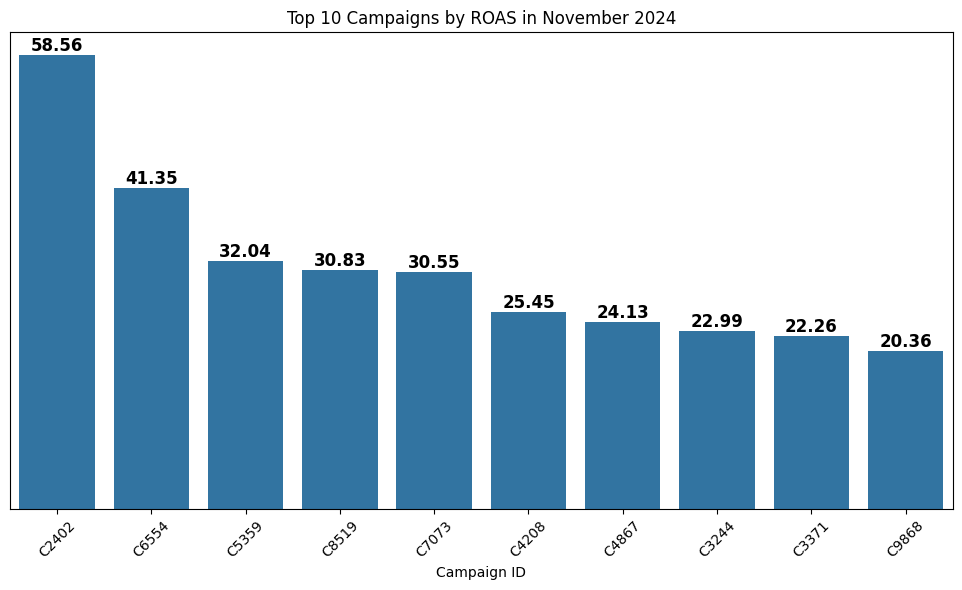

In [43]:
# 2. Phân tích top chiến dịch có ROAS cao trong tháng 11
top_roas_nov = campaign_11_2024.sort_values("ROAS", ascending=False).head(10)

plt.figure(figsize=(10,6))
ax = sns.barplot(
    data=top_roas_nov,
    x="Campaign_ID",
    y="ROAS"
)
plt.title("Top 10 Campaigns by ROAS in November 2024")
plt.xlabel("Campaign ID")
plt.ylabel("")  
plt.xticks(rotation=45)
plt.tight_layout()
ax.get_yaxis().set_visible(False)  

for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}',
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=12, color='black', fontweight='bold')
plt.show()

-> Có tồn tại những ngoại lệ

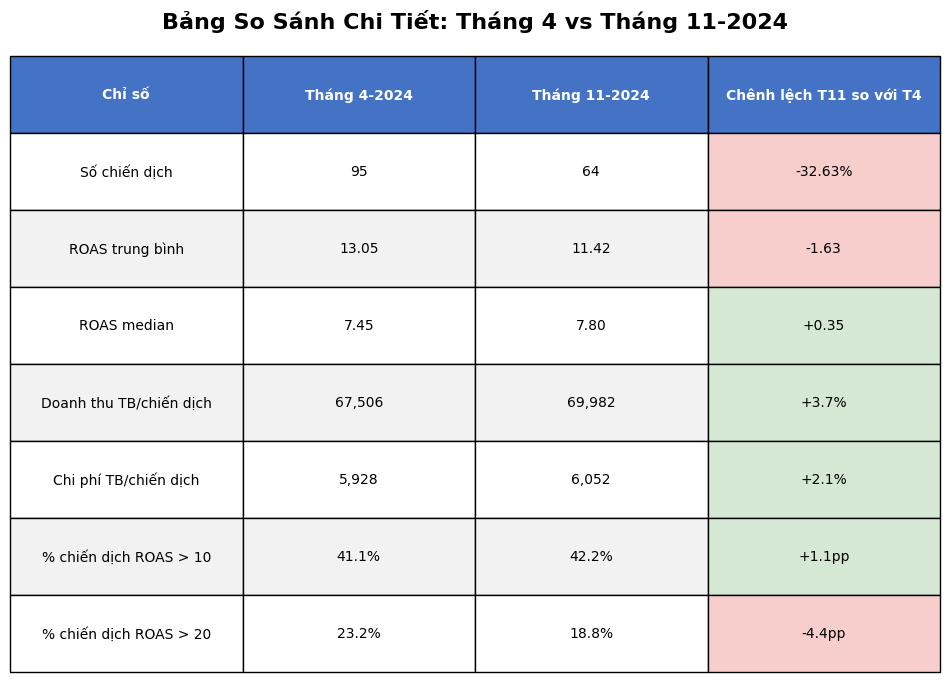

In [44]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.axis('tight')
ax.axis('off')

# Dữ liệu cho bảng
table_data = [
    ['Chỉ số', 'Tháng 4-2024', 'Tháng 11-2024', 'Chênh lệch T11 so với T4'],
    ['Số chiến dịch', f'{campaign_4_2024["Campaign_ID"].count()}', f'{campaign_11_2024["Campaign_ID"].count()}', f'{(campaign_11_2024["Campaign_ID"].count() - campaign_4_2024["Campaign_ID"].count())/campaign_4_2024["Campaign_ID"].count():.2%}'],
    ['ROAS trung bình', f'{campaign_4_2024["ROAS"].mean():.2f}', f'{campaign_11_2024["ROAS"].mean():.2f}', 
     f'{campaign_11_2024["ROAS"].mean() - campaign_4_2024["ROAS"].mean():+.2f}'],
    ['ROAS median', f'{campaign_4_2024["ROAS"].median():.2f}', f'{campaign_11_2024["ROAS"].median():.2f}',
     f'{campaign_11_2024["ROAS"].median() - campaign_4_2024["ROAS"].median():+.2f}'],
    ['Doanh thu TB/chiến dịch', f'{campaign_4_2024["Revenue"].mean():,.0f}', f'{campaign_11_2024["Revenue"].mean():,.0f}',
     f'+{((campaign_11_2024["Revenue"].mean() / campaign_4_2024["Revenue"].mean()) - 1) * 100:.1f}%'],
    ['Chi phí TB/chiến dịch', f'{campaign_4_2024["Spend"].mean():,.0f}', f'{campaign_11_2024["Spend"].mean():,.0f}',
     f'+{((campaign_11_2024["Spend"].mean() / campaign_4_2024["Spend"].mean()) - 1) * 100:.1f}%'],
    ['% chiến dịch ROAS > 10', 
     f'{(campaign_4_2024["ROAS"] > 10).sum() / len(campaign_4_2024) * 100:.1f}%',
     f'{(campaign_11_2024["ROAS"] > 10).sum() / len(campaign_11_2024) * 100:.1f}%',
     f'{((campaign_11_2024["ROAS"] > 10).sum() / len(campaign_11_2024) - (campaign_4_2024["ROAS"] > 10).sum() / len(campaign_4_2024)) * 100:+.1f}pp'],
    ['% chiến dịch ROAS > 20',
     f'{(campaign_4_2024["ROAS"] > 20).sum() / len(campaign_4_2024) * 100:.1f}%',
     f'{(campaign_11_2024["ROAS"] > 20).sum() / len(campaign_11_2024) * 100:.1f}%', 
     f'{((campaign_11_2024["ROAS"] > 20).sum() / len(campaign_11_2024) - (campaign_4_2024["ROAS"] > 20).sum() / len(campaign_4_2024)) * 100:+.1f}pp']
]

# Tạo bảng
table = ax.table(cellText=table_data[1:], colLabels=table_data[0], 
                cellLoc='center', loc='center',
                bbox=[0, 0, 1, 1])

# Styling cho bảng
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 2)

# Màu cho header
for i in range(4):
    table[(0, i)].set_facecolor('#4472C4')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Màu cho các hàng
for i in range(1, len(table_data)):
    for j in range(4):
        if i % 2 == 0:
            table[(i, j)].set_facecolor('#F2F2F2')
        
        # Highlight cột chênh lệch
        if j == 3:
            if '+' in str(table_data[i][j]):
                table[(i, j)].set_facecolor('#D5E8D4')
            elif '-' in str(table_data[i][j]):
                table[(i, j)].set_facecolor('#F8CECC')

plt.title('Bảng So Sánh Chi Tiết: Tháng 4 vs Tháng 11-2024', 
          fontsize=16, fontweight='bold', pad=20)
plt.show()

**Giảm thiểu ảnh hưởng của các ngoại lệ thì:**  
+ ROAS trung vị của tháng 11-2024 là nhỉnh hơn so với tháng 4-2024  
+ Doanh thu TB cũng cao hơn  
+ Mặc dù chi phí có tăng nhưng doanh thu trung bình đem về vẫn cao hơn.

**Kết luận điều tra**:  
Mặc dù tháng 11 có chiến dịch ít nhưng chiến dịch nào cũng đều chất lượng và không thua kém gì ROAS tháng 4 với số lượng chiến dịch nhiều hơn  
(Doanh thu trung bình cao hơn, chi phí thì tăng cũng chả đáng kể bằng so với doanh thu thu về)

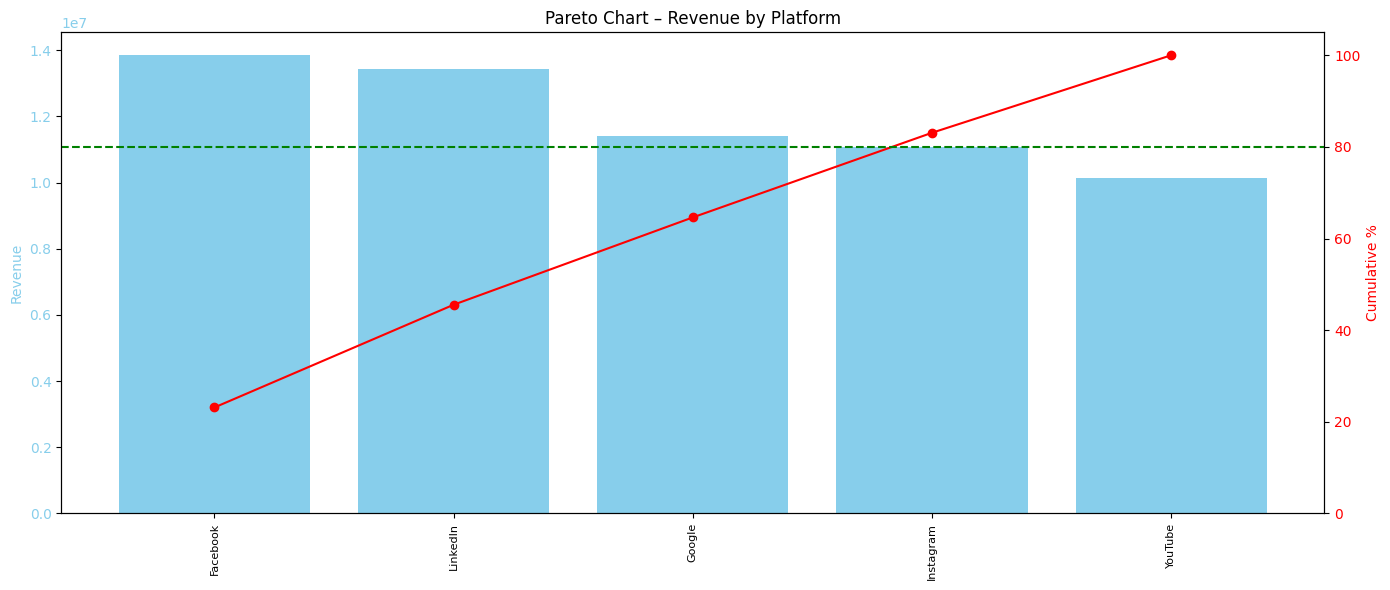

In [45]:
# Pareto 80/20: Revenue by Platform
revenue_sorted = df.groupby('Platform')['Revenue'].sum().sort_values(ascending=False)
revenue_sorted_pct = revenue_sorted.cumsum() / revenue_sorted.sum() * 100

plt.figure(figsize=(14,6))
ax1 = plt.subplot(111)
bars = ax1.bar(range(len(revenue_sorted)), revenue_sorted.values, color='skyblue')
ax1.set_xticks(range(len(revenue_sorted)))
ax1.set_xticklabels(revenue_sorted.index, rotation=90, ha='center', fontsize=8)
ax1.set_ylabel('Revenue', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')
ax1.set_title('Pareto Chart – Revenue by Platform')

ax2 = ax1.twinx()
ax2.plot(range(len(revenue_sorted)), revenue_sorted_pct.values, color='red', marker='o')
ax2.axhline(80, color='green', linestyle='--')
ax2.set_ylabel('Cumulative %', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(0,105)

plt.tight_layout()
plt.show()

-> Các kênh mang về doanh thu khá tương đồng, có thể là dấu hiệu của việc tiếp thị đa nền tảng

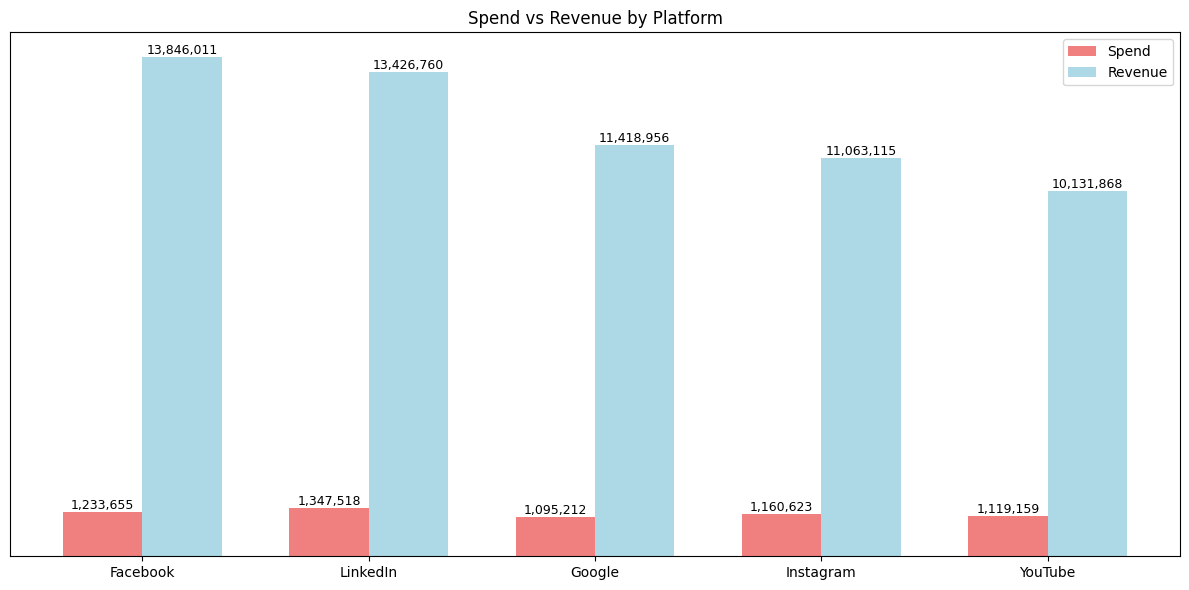

In [46]:
# Ta xem chi phí trên từng platform ra sao
cost_by_platform = df.groupby('Platform')[['Spend','Revenue']].sum().sort_values(ascending=False,by=['Revenue'])

# Vẽ biểu đồ cột kép cho chi phí và doanh thu theo nền tảng
plt.figure(figsize=(12, 6))

# Tạo vị trí cho các cột
x = range(len(cost_by_platform))
width = 0.35

# Vẽ cột kép
bars1 = plt.bar([i - width/2 for i in x], cost_by_platform['Spend'].values, width, 
                label='Spend', color='lightcoral')
bars2 = plt.bar([i + width/2 for i in x], cost_by_platform['Revenue'].values, width,
                label='Revenue', color='lightblue')

# Tùy chỉnh biểu đồ
plt.title('Spend vs Revenue by Platform')
plt.xticks(x, cost_by_platform.index)
plt.legend()
plt.gca().get_yaxis().set_visible(False)  # Ẩn trục y

# Thêm giá trị trên từng cột
for i, value in enumerate(cost_by_platform['Spend'].values):
    plt.text(i - width/2, value, f'{value:,.0f}', ha='center', va='bottom', fontsize=9)

for i, value in enumerate(cost_by_platform['Revenue'].values):
    plt.text(i + width/2, value, f'{value:,.0f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

In [47]:
# Ta tiếp tục xây watchlist
# Watchlist gồm cột: Platform, ROAS_pct_change, CPA_recent 
# ROAS_pct_change: Cột này tôi sẽ tập trung vào tính ROAS 30 chiến dịch gần nhất cho từng platform 
# rồi so sánh với 30 chiến dịch trước đó xem percentage change của ROAS có nhỏ hơn X% không: nếu có tô đỏ, không thì tô xanh, còn không tô vàng
# Rồi vẫn bảng đó sẽ có thêm cột CPA_recent: tính CPA của 30 chiến dịch gần nhất cho từng platform rồi so sánh với CPA đặt ra (do Business Manager đặt ra)

In [48]:
df = df.sort_values(by="Month_Year", ascending=False)

In [49]:
def watchlist(df, threshold_cpa, threshold_roas_pct_change, day_calculate):
    watchlist = pd.DataFrame(columns=["Platform", "ROAS_pct_change", "CPA_recent"])
    for platform in df.Platform.unique():
        df_platform = df[df.Platform == platform]
        
        # Tính cho {day_calculate} chiến dịch gần nhất
        recent_df = df_platform.iloc[:day_calculate].groupby("Platform").agg({
            "Revenue": "sum", # Dùng để tính ROAS
            "Spend": "sum",   # Dùng để tính ROAS
            "Conversions": "sum", # Dùng để tính CPA
            "Budget": "sum"   # Dùng để tính CPA
        })
        # Tính cho {day_calculate} chiến dịch trước đó
        old_df = df_platform.iloc[day_calculate:day_calculate*2].groupby("Platform").agg({
            "Revenue": "sum", # Dùng để tính ROAS
            "Spend": "sum",   # Dùng để tính ROAS
            "Conversions": "sum", # Dùng để tính CPA
            "Budget": "sum"   # Dùng để tính CPA
        })
        
        # Tính ROAS recent và old
        recent_df["ROAS_recent"] = recent_df["Revenue"] / recent_df["Spend"]
        old_df["ROAS_old"] = old_df["Revenue"] / old_df["Spend"]
        
        # Tính CPA recent và old
        recent_df["CPA_recent"] = recent_df["Budget"] / recent_df["Conversions"]
        old_df["CPA_old"] = old_df["Budget"] / old_df["Conversions"]

        # Tính ROAS_pct_change:
        roas_pct_change = ((recent_df["ROAS_recent"].iloc[0] - old_df["ROAS_old"].iloc[0]) / old_df["ROAS_old"].iloc[0]) if not old_df.empty and old_df["ROAS_old"].iloc[0] != 0 else 0
        cpa_recent = recent_df["CPA_recent"].iloc[0] if not recent_df.empty else 0
        watchlist.loc[len(watchlist)] = [platform, roas_pct_change, cpa_recent]
        
    # In ra những platform có ROAS_pct_change > threshold_roas_pct_change và CPA_recent < threshold_cpa (1 chiến dịch hoàn hảo):
    print(f"=========== Những chiến dịch có: {day_calculate} chiến dịch gần đây với ROAS giảm {threshold_roas_pct_change*100:.0f}% so với {day_calculate} trước đó ===========")
    bad_roas_platform = watchlist[(watchlist["ROAS_pct_change"] < threshold_roas_pct_change)]["Platform"]
    if len(bad_roas_platform) == 0:
        print("Không có chiến dịch nào")
    else:
        print(bad_roas_platform)

    print()
    
    print(f"=========== Những chiến dịch có: {day_calculate} chiến dịch gần đây với CPA vượt ngưỡng {threshold_cpa:.2F} ===========")
    high_cpa_platform = watchlist[(watchlist["CPA_recent"] > threshold_cpa)]["Platform"]
    if len(high_cpa_platform) == 0:
        print("Không có chiến dịch nào")
    else:
        print(high_cpa_platform)

    print()
    
    print(f"=========== Những chiến dịch: vừa ROAS giảm {threshold_roas_pct_change*100:.0f}% vừa CPA vượt ngưỡng {threshold_cpa:.2F} ===========")
    print(np.intersect1d(bad_roas_platform, high_cpa_platform))
    
    # return watchlist

In [50]:
watchlist(df,12, -0.12, 30)

=========== Những chiến dịch có: 30 chiến dịch gần đây với ROAS giảm -12% so với 30 trước đó ===========
3    Google
Name: Platform, dtype: object

=========== Những chiến dịch có: 30 chiến dịch gần đây với CPA vượt ngưỡng 12.00 ===========
0    Instagram
1      YouTube
3       Google
4     LinkedIn
Name: Platform, dtype: object

=========== Những chiến dịch: vừa ROAS giảm -12% vừa CPA vượt ngưỡng 12.00 ===========
['Google']


-> Nếu chọn ngưỡng như của tôi thì chúng ta thấy rằng dường như Google Ads đang là kênh đang tiêu tốn nhiều nhất mà chẳng mang về doanh thu

### **Dashboard 2: Phân tích Kênh, Nội dung, Khu vực và Thiết bị**